In [1]:
import time

import numpy as np
import pyro
import pyro.contrib.examples.multi_mnist as multi_mnist
from pyro.infer import (
    SVI,
    RenyiELBO,
    TraceGraph_ELBO,
    TraceEnum_ELBO,
    ReweightedWakeSleep,
)
from pyro.optim import Adam
import pandas as pd

import torch
from pyro_air import AIR, make_prior, get_per_param_lr, count_accuracy, visualize_model

In [2]:
#####################
# Benchmark Configs
#####################
seed = 123456
use_cuda = torch.cuda.is_available()
batch_size = 64
num_epoches = 41

z_pres_prior = 0.01
learning_rate = 1e-4
baseline_lr = 1e-1
elbo = TraceGraph_ELBO()
# explicitly list out all configurable options
air_model_args = dict(
    num_steps=3,
    x_size=50,
    window_size=28,
    z_what_size=50,
    rnn_hidden_size=256,
    encoder_net=[200],
    decoder_net=[200],
    predict_net=[200],
    embed_net=None,
    bl_predict_net=[200],
    non_linearity="ReLU",
    decoder_output_bias=-2,
    decoder_output_use_sigmoid=True,
    use_masking=True,
    use_baselines=True,
    baseline_scalar=None,
    scale_prior_mean=3.0,
    scale_prior_sd=0.2,
    pos_prior_mean=0.0,
    pos_prior_sd=1.0,
    likelihood_sd=0.3,
    use_cuda=use_cuda,
)

In [3]:
#####################
# Initial Setup
#####################
device = torch.device("cuda" if use_cuda else "cpu")
z_pres_prior_fn = lambda t: [0.008, 5.12e-07, 3.2768e-11][t]

X, Y = multi_mnist.load("data/air/.data")
X = (torch.from_numpy(X).float() / 255.0).to(device)
visualize_examples = X[5:10]
# Using float to allow comparison with values sampled from
# Bernoulli.
true_counts = torch.tensor([len(objs) for objs in Y], dtype=torch.float)

/home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/pyro/util.py:544: UserWarning: z_pres_0Found sample sites configured for enumeration:, z_pres_1Found sample sites configured for enumeration:, z_pres_2
If you want to enumerate sites, you need to use TraceEnum_ELBO instead.
  warnings.warn(


Epoch=0, current_epoch_step_time=40.82, loss=-482.07
accuracy=0.7362499833106995, counts=tensor([[18979,   968,     1,     0],
        [ 2220, 16052,  1679,    69],
        [   66,  9828,  9144,   994]])


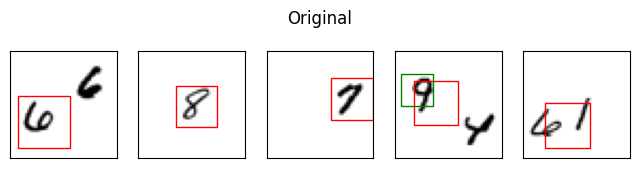

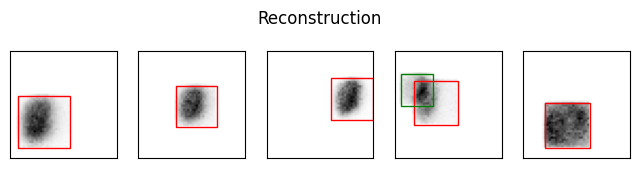

Epoch=1, current_epoch_step_time=40.53, loss=-547.18
Epoch=2, current_epoch_step_time=39.96, loss=-575.85
Epoch=3, current_epoch_step_time=39.83, loss=-588.70
Epoch=4, current_epoch_step_time=39.19, loss=-596.97
Epoch=5, current_epoch_step_time=38.78, loss=-602.42
accuracy=0.9682666659355164, counts=tensor([[19939,     9,     0,     0],
        [  118, 19471,   430,     1],
        [    0,  1314, 18686,    32]])


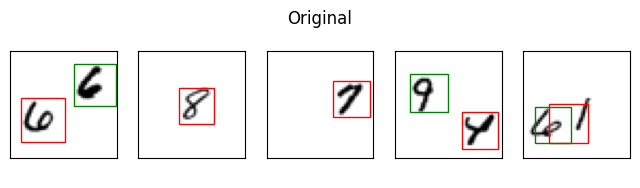

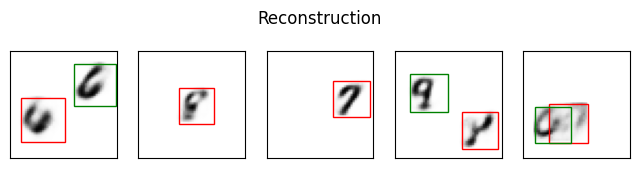

Epoch=6, current_epoch_step_time=38.57, loss=-606.23
Epoch=7, current_epoch_step_time=38.73, loss=-609.63
Epoch=8, current_epoch_step_time=39.69, loss=-613.62
Epoch=9, current_epoch_step_time=38.84, loss=-615.46
Epoch=10, current_epoch_step_time=39.08, loss=-618.82
accuracy=0.9742333292961121, counts=tensor([[19947,     1,     0,     0],
        [   68, 19799,   152,     1],
        [    0,  1318, 18708,     6]])


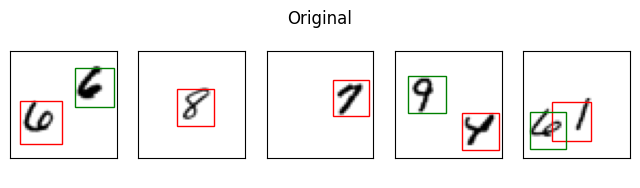

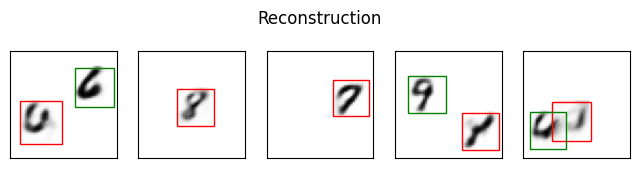

Epoch=11, current_epoch_step_time=39.61, loss=-620.58
Epoch=12, current_epoch_step_time=39.48, loss=-621.66
Epoch=13, current_epoch_step_time=39.38, loss=-623.44
Epoch=14, current_epoch_step_time=39.09, loss=-625.74
Epoch=15, current_epoch_step_time=39.41, loss=-626.60
accuracy=0.9806333184242249, counts=tensor([[19947,     1,     0,     0],
        [   18, 19833,   169,     0],
        [    0,   969, 19058,     5]])


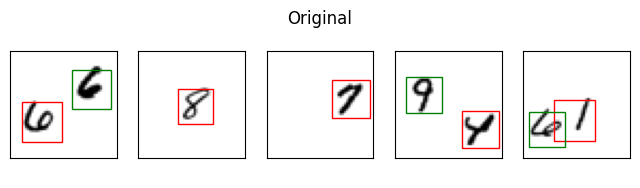

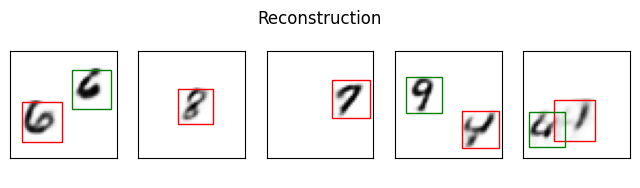

Epoch=16, current_epoch_step_time=39.01, loss=-628.79
Epoch=17, current_epoch_step_time=39.25, loss=-628.93
Epoch=18, current_epoch_step_time=39.70, loss=-630.17
Epoch=19, current_epoch_step_time=39.29, loss=-631.62
Epoch=20, current_epoch_step_time=39.63, loss=-631.65
accuracy=0.984083354473114, counts=tensor([[19947,     1,     0,     0],
        [   26, 19813,   181,     0],
        [    0,   739, 19285,     8]])


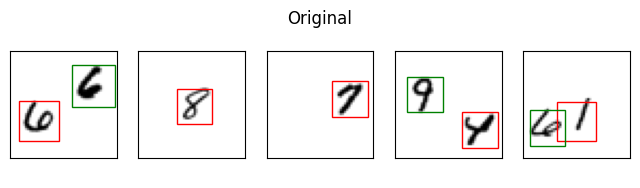

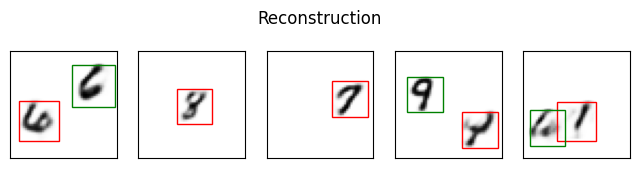

Epoch=21, current_epoch_step_time=39.58, loss=-632.46
Epoch=22, current_epoch_step_time=39.15, loss=-633.13
Epoch=23, current_epoch_step_time=39.80, loss=-633.25
Epoch=24, current_epoch_step_time=39.27, loss=-634.01
Epoch=25, current_epoch_step_time=39.81, loss=-634.68
accuracy=0.9854666590690613, counts=tensor([[19948,     0,     0,     0],
        [   20, 19840,   160,     0],
        [    0,   689, 19340,     3]])


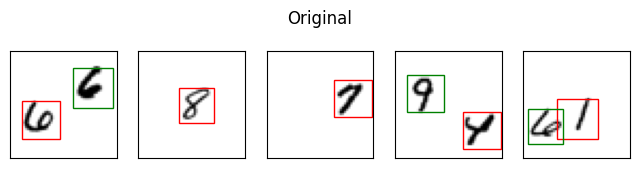

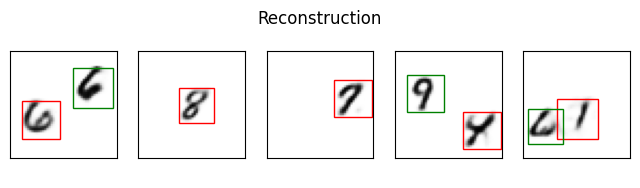

Epoch=26, current_epoch_step_time=39.89, loss=-635.68
Epoch=27, current_epoch_step_time=39.54, loss=-636.23
Epoch=28, current_epoch_step_time=40.11, loss=-636.44
Epoch=29, current_epoch_step_time=39.15, loss=-636.36
Epoch=30, current_epoch_step_time=39.81, loss=-637.29
accuracy=0.9860166907310486, counts=tensor([[19948,     0,     0,     0],
        [   16, 19882,   122,     0],
        [    0,   698, 19331,     3]])


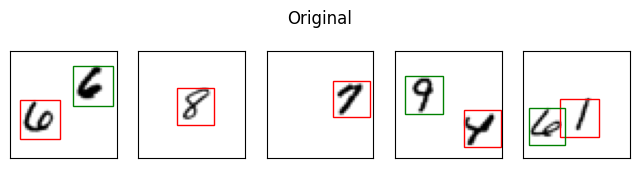

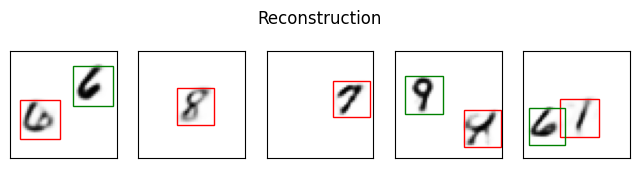

Epoch=31, current_epoch_step_time=39.93, loss=-637.63
Epoch=32, current_epoch_step_time=39.85, loss=-637.71
Epoch=33, current_epoch_step_time=39.75, loss=-638.62
Epoch=34, current_epoch_step_time=39.40, loss=-638.74
Epoch=35, current_epoch_step_time=40.04, loss=-639.22
accuracy=0.9869666695594788, counts=tensor([[19948,     0,     0,     0],
        [   15, 19843,   162,     0],
        [    0,   603, 19427,     2]])


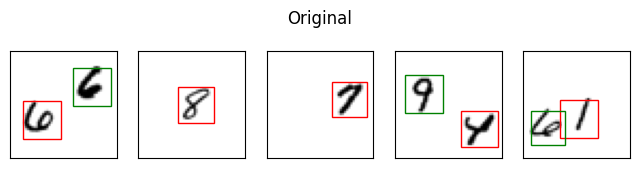

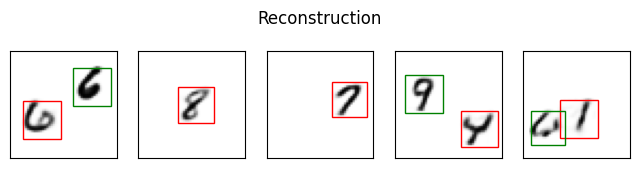

Epoch=36, current_epoch_step_time=39.59, loss=-639.26
Epoch=37, current_epoch_step_time=39.19, loss=-639.82
Epoch=38, current_epoch_step_time=39.63, loss=-639.98
Epoch=39, current_epoch_step_time=39.76, loss=-639.90
Epoch=40, current_epoch_step_time=39.32, loss=-640.19
accuracy=0.9865833520889282, counts=tensor([[19948,     0,     0,     0],
        [   12, 19913,    95,     0],
        [    0,   697, 19334,     1]])


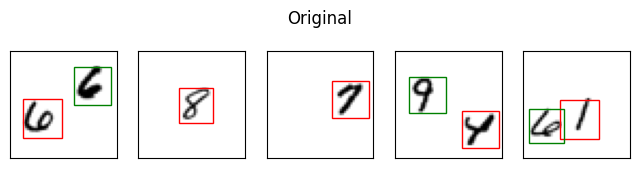

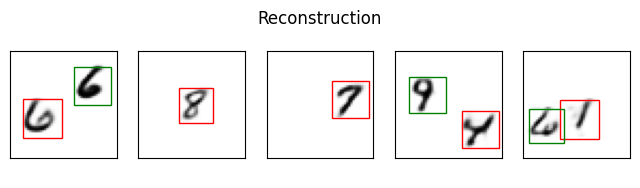

In [4]:
if seed is not None:
    pyro.set_rng_seed(seed)
pyro.distributions.enable_validation(False)
pyro.clear_param_store()  # just in case

air = AIR(**air_model_args)
adam = Adam(get_per_param_lr(learning_rate, baseline_lr))
svi = SVI(air.model, air.guide, adam, loss=elbo)

all_loss = []
all_accuracy = []
time_per_epoch = []

for i in range(num_epoches):
    start_time = time.perf_counter()
    # technically this might step over slightly more than 1 epoch...
    losses = []
    for j in range(int(np.ceil(X.size(0) / batch_size))):
        losses.append(
            svi.step(X, batch_size=batch_size, z_pres_prior_p=z_pres_prior_fn)
        )
    end_time = time.perf_counter()

    accuracy, counts, error_z, error_ix = count_accuracy(X, true_counts, air, 1000)

    all_loss.append(np.mean(losses) / X.size(0))
    all_accuracy.append(accuracy)
    time_per_epoch.append(end_time - start_time)

    print(
        f"Epoch={i}, current_epoch_step_time={time_per_epoch[-1]:.2f}, loss={all_loss[-1]:.2f}"
    )
    if i % 5 == 0:
        print(f"accuracy={accuracy}, counts={counts}")
        visualize_model(visualize_examples, air)

In [5]:
wall_clock_times = np.cumsum(time_per_epoch)
arr = np.array([all_loss, all_accuracy, wall_clock_times])
df = pd.DataFrame(arr.T, columns=["ELBO Loss", "Accuracy", "Epoch wall clock times"])
df.to_csv(
    "./training_runs/pyro_trace_graph_elbo_baselines_bsize64_mccoy_prior.csv",
    index=False,
)